# The Need for Speed

Joshua P. French  
November 8, 2023

To open this information in an interactive Colab notebook, click the
Open in Colab graphic below.

<a href="https://colab.research.google.com/github/jfrench/DataWrangleViz/blob/master/the-need-for-speed.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg">
</a>

------------------------------------------------------------------------

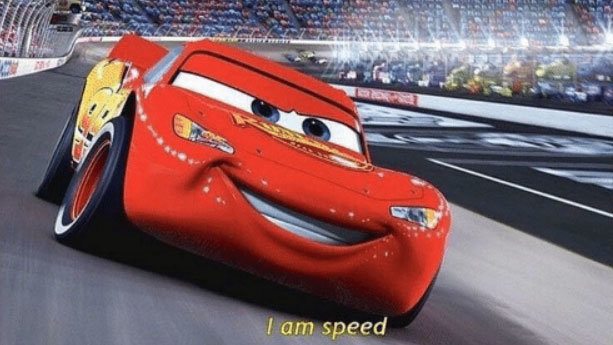

## Tips for optimizing matrix algebra operations ([YouTube](https://youtu.be/cBovzIQvw78), [Panopto](https://ucdenver.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=5e2bb274-0855-40ef-a60e-b09e015fec12))

It is straightforward to perform matrix algebra in R. However, it is
more difficult to write *efficient* (faster) matrix code. We provide
some basic tips below.

### `crossprod` and `tcrossprod`

The `crossprod` and `tcrossprod` functions are faster approaches to
performing matrix multiplication when one of the matrices must first be
transposed.

If we have matrices `A` and `B` of compatible dimensions, then:

-   `t(A) %*% B` is equivalent to `crossprod(A, B)`.
-   `A %*% t(B)` is equivalent to `tcrossprod(A, B)`.

`crossprod` and `tcrossprod` are faster than their equivalent approaches
because the equivalent approaches compute the transpose of matrix in
memory before performing the multiplication. The `crossprod` and
`tcrossprod` functions modify their multiplication algorithms so that
the transpose matrix doesn’t have to be created prior to multiplication.

To illustrate this difference, we create `A`, a $50\times 2$ matrix of
values and `B`, a $50 \times 2$ matrix of values by drawing the
appropriate number of values from a standard normal distribution. We use
the `set.seed` function to make the example reproducible.

In [1]:
set.seed(314)
A <- matrix(rnorm(100), ncol = 2)
B <- matrix(rnorm(100), ncol = 2)

First, we use the `all.equal` function to confirm that the standard and
optimized approaches produce the same results. `all.equal` confirms that
the supplied objects are equal to each other.

In [2]:
all.equal(t(A) %*% B, crossprod(A, B))

In [3]:
all.equal(A %*% t(B), tcrossprod(A, B))

We will use the `microbenchmark` function from the **microbenchmark**
package (Mersmann 2023) to time the optimized and standard approaches to
computing $\mathbf{A}^T \mathbf{B}$ and $\mathbf{A} \mathbf{B}^T$.

We start by loading the **microbenchmark** package.

In [4]:
library(microbenchmark)

We now compute $\mathbf{A}^T \mathbf{B}$ using the standard approach and
using `crossprod` within the `microbenchmark` function. The
`microbenchmark` function will perform each computation 100 times by
default to determine the typical speed. We then use the `plot` function
to plot the results.

In [5]:
t1 <- microbenchmark::microbenchmark(t(A) %*% B, crossprod(A, B))
plot(t1)

While the results shown in the above plot will depend on the speed of
the computer used to perform the calculation, the boxplot shown for
`crossprod(A, B)` should be lower then `t(A) %*% B`, which means the
`crossprod` approach is faster than the standard approach.

We perform a simialr analysis for computing $\mathbf{A}\mathbf{B}^T$.

In [6]:
t2 <- microbenchmark(A %*% t(B), tcrossprod(A, B))
plot(t2)

Once again, the plot of our timing results should show that
`tcrossprod(A, B)` can be computed faster than `A %*% t(B)`.

### Order of matrix multiplication

Matrix multiplication is associative, meaning that if we have compatible
matrices $\mathbf{A}$, $\mathbf{B}$ and $\mathbf{C}$, then
$$(\mathbf{A B})\mathbf{C} = \mathbf{A} (\mathbf{B C}).$$

The order of matrix multiplication can greatly impact how long it takes
to perform the operations.

**Prioritize performing operations that produce smaller matrices
first.** Smaller can mean the total number of rows/columns or long/thin
matrices, depending on the context.

We create three matrices below filled with random values: `A` is a
matrix of size $500\times 2$, `B` is a matrix of size $2 \times 50$, `C`
is a $50\times 1$ column vector.

In [7]:
set.seed(1999)
A <- matrix(rnorm(1000), ncol = 2)
B <- matrix(rnorm(100), nrow = 2)
C <- rnorm(50)

Computing $\mathbf{A}(\mathbf{BC})$ is much faster than computing
$(\mathbf{AB})\mathbf{C}$ because $\mathbf{BC}$ first produces
$2\times 1$ matrix while $\mathbf{AB}$ produces a much larger
$500 \times 50$ matrix.

We confirm this by timing these operations using the `microbenchmark`
function and plotting the results.

In [8]:
t3 <- microbenchmark((A %*% B) %*% C,
                     A %*% (B %*% C))
plot(t3, las = 2, cex.axis = 0.5)

## Loops versus vectorization ([YouTube](https://youtu.be/0AlZW5ZGvvg), [Panopto](https://ucdenver.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=4bf55aac-da5d-4824-92f2-b0af01266aec))

Loops in R are notoriously slow.

When possible, we should prefer *vectorized operations* over loops.

A **vectorized** operation uses a fast, pre-compiled function to apply
an operation to all elements of a vector, matrix, list, etc., without
using a loop.

Here is a trivial example demonstrating the the speed and power of
vectorization over loops.

Let’s say we want to compute the cumulative sum of a set of numeric
values. The cumulative sum of a vector of numeric values is the sum of
each value and all the previous values in the vector. The cumulative sum
of the vector $[1, 2, 4]$ is $[1, 3, 7]$.

We create a function, `cumsum_loop`, to compute the cumulative sum of a
numeric vector. We describe our approach:

-   The function takes, `x`, which we assume is a numeric vector.
-   We create a vector, `results`, to store our cumulative sums.
-   We create a `for` loop to iterate `i` over every element of `x`. For
    each value of `i`, we:
    -   Check if we are considering the first element of `x`. If we are,
        then `results[i]` is simply the value in the first position of
        `x`.
    -   If we are not considering the first element of `x`, then the
        cumulative sum of the first `i` elements of `x` is the value in
        the $i$th position of `x`, `x[i]`, plus the previous value of
        the cumulative sum, `results[i - 1]`.
-   After we iterating over all positions of `x`, we return the
    `results` vector.

In [9]:
cumsum_loop <- function(x) {
  # create vector of results
  results <- numeric(length(x))
  for (i in 1:length(x)) {
    if (i == 1) {
      results[i] <- x[i]
    } else {
      results[i] <- results[i - 1] + x[i]
    }
  }
  return(results)
}

Let’s try this function on the vector $[1, 2, 4]$.

In [10]:
cumsum_loop(c(1, 2, 4))

What is wrong with this function? Nothing, really. Except that it’s slow
compared to the equivalent vectorized version of this calculation.

The `cumsum` function is a vectorized version of a cumulative sum that
relies on fast, pre-compiled code. We can see that it gives the same
results as the function we created.

In [11]:
cumsum(c(1, 2, 4))

We use the `microbenchmark` function in the **microbenchmark** package
(Mersmann 2023) to compare the timings of `cumsum_loop` and `cumsum`.
The `microbenchmark` function will run the provided functions 100 times,
by default.

-   We sample 1000 values from a standard normal distribution.,
-   We use `microbenchmark` to time how long it takes to compute the
    cumulative sum of the sampled values using both cumulative sum
    functions. We repeat this timing 100 times for each function.
-   We plot the results for comparison.

In [12]:
# attach microbenchmark
library(microbenchmark) 
# draw 1000 values from a N(0, 1) distribution
x <- rnorm(1000)
# compute the cumulative sum 100 times using both approaches
cumsum_timings <- microbenchmark(cumsum_loop(x), cumsum(x))
# plot timing results
plot(cumsum_timings)

While the exact timing results will depend on the computer the timings
are performed on, the plot above will clearly show that the vectorized
`cumsum` function is substantially faster than the `cumsum_loop`
function.

These results may seem trivial, but for large data sets where these
operations are performed thousands or millions of times, vectorized
operations can be many orders of magnitude faster than loops.

# The vectorized \*apply functions ([YouTube](https://youtu.be/nl-ktoJriH8), [Panopto](https://ucdenver.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=92d3b13f-35c1-4829-bd79-b0ad010b20ed))

The `*apply` functions are a set of vectorized functions that can be
applied different object types. The “`*`” in `*apply` is a “wildcard”
character, meaning that it can be any set of characters.

`*apply` functions will typically perform operations much faster than
equivalent operations implemented using loops. `*apply` functions also
make code simpler and more elegant.

[Table 1](#tbl-apply) summarizes the various `*apply` functions
available by default in R.

| name     | description                                                                                |
|:-----|:-----------------------------------------------------------------|
| `apply`  | Applies a function to the margins of a data frame, matrix, or array.                       |
| `lapply` | Applies a function to each element of a list.                                              |
| `sapply` | A version of `lapply` that attempts to simplify the results to a vector, matrix, or array. |
| `vapply` | A safer version of `sapply` that returns a pre-specified type of return value.             |
| `tapply` | Applies a function to a vector or data frame based on the levels of a categorical variable |
| `mapply` | A multivariate version of `sapply`.                                                        |

Table 1: A summary of the various `*apply` functions available in R.

## The `apply` function ([YouTube](https://youtu.be/iWq_EsrXhjQ), [Panopto](https://ucdenver.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=98faa071-9645-4c1c-afe8-b0ad010c0e64))

The `apply` function applies a function to a margin (dimension) of a
data frame, matrix, or array.

The primary arguments of the `apply` function are:

-   `X`: A data frame, `matrix`, or `array`.
-   `MARGIN`: a vector indicating the dimension to apply the function
    to. `1` indicates rows, `2` indicates columns, `3` indicates the
    third dimension of an array, `1:2` indicates row and columns, etc.
-   `FUN`: the function to be applied to the margins of `X`.
-   `...`: additional arguments that need to be passed to `FUN`.
-   `simplify`: a logical value indicating whether results should be
    simplified, if possible. The default is `TRUE`.

We provide several examples using the `apply` function below.

Consider the matrix `mat` below.

In [14]:
mat <- cbind(1:5, 6:10)
mat

We can compute the mean value for each row of `mat` by running the
command below.

In [15]:
apply(X = mat, MARGIN = 1, FUN = mean)

We can compute the mean value for each column of `mat` by running the
command below.

In [16]:
apply(mat, 2, mean)

Note that the `rowMeans` and `colMeans` functions would have produced
the same results, with simpler code. However, the examples above are
simple examples to illustrate usage of the `apply` function.

What if we want to apply a function that has arguments we need to
specify? E.g., let’s say we want to compute the 0.8 quantile of a set of
values in a numeric vector `x`. We could run the command
`quantile(x, prob = 0.8)`. How can we use a function like this with the
`apply` function?

The code below uses `apply` to compute the 0.8 quantile for each column
of `mat`.

In [17]:
apply(mat, 2, quantile, prob = 0.8)

Lastly, we consider a basic application of the `apply` function a
3-dimensional array.

We create a 3-dimensional array with dimension $3\times 2 \times 4$
below.

In [18]:
A <- array(1:24, dim = c(3, 2, 4))
print(A)

Let’s compute means for each row of `A`.

In [19]:
apply(A, 1, mean)

`11.5` comes from averaging all the values in the 1st row of `A` across
all columns and the third dimension:
`(1 + 4 + 7 + 10 + 13 + 16 + 19 + 22)/8 = 11.5`. More simply, it is
equivalent to running the following command.

In [20]:
mean(A[1,,])

`12.5` and `13.5` come from averaging all the values in the second and
third rows of `A`, respectively.

Let’s compute the sums across the third dimension of `A`.

In [21]:
apply(A, 3, sum)

`21` comes from adding all the values in the first element of the third
dimension of `A`. More specifically, it is equivalent to running the
following command.

In [22]:
sum(A[,,1])

Let’s compute the means across the row and columns of `A`.

In [23]:
apply(A, 1:2, mean)

The command above returns the values obtained by averaging all of the
values in a particular row and column of `A` across the third dimension
of `A`.

`10` comes from averaging the values in `A[1, 1, 1]`, `A[1, 1, 2]`,
`A[1, 1, 3]`, `A[1, 1, 4]`, i.e., `(1 + 7 + 13 + 19)/4 = 10`.
Alternatively, it is equivalent to running the following command.

In [24]:
mean(A[1, 1, ])

## The `lapply`, `sapply`, and `vapply` functions ([YouTube](https://youtu.be/4RjlOShPeU0), [Panopto](https://ucdenver.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=53c2f52e-8419-4846-83f7-b0ad010c9c25))

The `lapply` function applies a function to each element of an atomic
vector or list. It is very convenient for performing analyses in
simulation studies. The `lapply` function always returns a list.

The arguments of the `lapply` function are:

-   `X`: An atomic vector or list.
-   `FUN`: the function to be applied to each element of `X`.
-   `...`: additional arguments that need to be passed to `FUN`.

We start with a simple example that computes the sample mean of a `list`
containing numeric vectors.

We first define the our `list`.

In [25]:
simple_list <- list(1:10, 11:20)
simple_list

We then use `lapply` to compute the sample mean of each element of
`sample_list`.

In [26]:
lapply(simple_list, mean)

The `sapply` function attempts to coerce the results of `lapply` to a
`vector`, `matrix`, or `array` (whichever is simplest) using the
`simplify2array` function. Technically, the `sapply` function has two
additional arguments compared to `lapply`:

-   `simplify`: a logical value indicating whether the `sapply` should
    attempt to simplify the result using `simplify2array`. The default
    is `TRUE`.
-   `USE.NAMES`: a logical value indicating whether names should be
    associated with the results. The default is `TRUE`.

We repeat the previous example using `sapply`.

In [27]:
sapply(simple_list, mean)

Instead of returning a `list` object with elements `5.5` and `15.5`, we
get a vector with the same elements.

The `sapply` function *seems* like it is the more convenient version of
`lapply`, but this is a trap. The `sapply` function can produce
unexpected results because it is not required to return an object of a
specific type. The result may change depending on the input.

Let’s create a second list, `simple_list2`, with two elements: the first
element is a vector of 3 numeric values and the second element is a
vector of 4 numeric values.

In [28]:
simple_list2 <- list(1:3, 4:7)
simple_list2

We create a function, `add2`, that takes a `numeric` vector `x` and adds
2 to all the elements in `x`.

In [29]:
add2 <- function(x) {
  x + 2
}

We confirm that `add2` works as intended.

In [30]:
add2(2:3)

If we use `sapply` to apply `add2` to each element of `simple_list`, the
result is returned as a `matrix` because the results can be simplified
by `simplify2array`.

In [31]:
sapply(simple_list, add2)

If we apply `add2` to each element of `simple_list2`, the result is
returned as a `list` because the results cannot be simplified by
`simplify2array`.

In [32]:
sapply(simple_list2, add2)

We don’t always know that data type the `sapply` function will return,
which is dangerous if we use those results in any future calculations.

The `vapply` function attempts to be a safer version of `sapply` by
requiring the user to indicate the data type expected from each
application of `FUN`. However, `vapply` also attempts to simplify the
output using `simplify2array`, so it can also create issues in later
code.

The `vapply` function essentially adds one additional argument to
`sapply`.

-   `FUN.VALUE`: a template for the value returned by `FUN`.

If `FUN` doesn’t have the same structure as `FUN.VALUE`, then `vapply`
returns an error.

Let’s create a trivial example. We create two lists, `l1` and `l2`.

-   `l1` has two elements containing `integer` vectors.
-   `l2` has two elements containing `double` vectors.

In [33]:
l1 <- list(seq.int(1, 4), seq.int(4, 7))
l1

In [34]:
l2 <- list(seq(1.5, 4.5, by = 1), seq(4.5, 7.5, by = 1))
l2

We apply the `max` function to `l1` using `vapply`. We specify
`FUN.VALUE = integer(1)` to indicate that each time we apply the `max`
function to an element of `l1`, we expect to get an `integer` vector of
length 1.

In [35]:
vapply(l1, max, FUN.VALUE = integer(1))

We get an error if we do the same thing for `l2` because the `max`
function will return an atomic vector of type `double` of length 1. The
error produced by `vapply` indicates that it was expecting to get an
`integer` type by got a `double` type instead.

In [36]:
vapply(l2, max, FUN.VALUE = integer(1))

We can correct the problem by changing `FUN.VALUE` to `double(1)`.

In [37]:
vapply(l2, max, FUN.VALUE = double(1))

We should not use `sapply` or `vapply` inside any function to avoid
problems with the output change data types. Instead, use the `lapply`
function to keep the output consistent.

### Bootstrap confidence interval example ([YouTube](https://youtu.be/IBuJSRu9Quw), [Panopto](https://ucdenver.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=88db6193-d823-4c75-a00b-b0ad010d3fb3))

A confidence interval procedure produces plausible values for a target
parameter with an associated confidence level.

-   If we repeatedly obtain samples from a population, a confidence
    interval procedure will produce intervals containing the target
    parameter with probability equal to the confidence level.

Confidence intervals are typically constructed on the assumption that we
know the population distribution from which the sample came.

A bootstrap confidence interval procedure can be used to construct
confidence intervals when the population distribution is unknown.

More generally, the bootstrap method allows us to approximate the
sampling distribution of a statistic by using the observed data to
produce simulated data sets.

Suppose we have a sample of $n$ data values, $x_1, x_2, \ldots, x_n$.
Suppose we want to estimate the mean, $\mu$, of the population from
which the sample came. A natural estimator of $\mu$ is the sample mean,
$\bar{x}$.

The procedure for producing a bootstrap confidence interval for $\mu$
with confidence level $1-\alpha$ is:

1.  Sample with replacement a data set of size $n$ from the observed
    data values. This is a bootstrap sample.
2.  Compute $\bar{x}$ for the random sample.
3.  Perform steps 1 and 2 $B$ times, where $B$ is a number like 1000 or
    10000.
4.  Compute the $\alpha/2$ and $1-\alpha/2$ quantiles of the sample
    means obtained from the bootstrap samples.

Suppose we have observed the following sample:

3.318, 4.940, 5.516, 2.958, 6.098, 6.858, -0.539, 2.544, 4.091, 1.884

Let’s construct a 95% bootstrap confidence interval for the population
mean, $\mu$, using the sample data. We will build a function to
construct our bootstrap confidence interval that is based on `lapply`.
Our function will take three arguments:

-   `x`: A vector of numeric values.
-   `conf.level`: The confidence level desired for the interval. The
    default value will be `0.95`.
-   `B`: The number of bootstrap samples from which to build the
    confidence interval. The default value will be `1000`.

The function will perform the following actions:

-   Determine `alpha` from `confidence.level`.
-   The `lapply` function is applied to each element of the atomic
    vector `1:B`.
-   We supply an *anonymous* function to the `FUN` argument of `lapply`.
    An anonymous function is a temporary function we create to perform
    an action but for which we don’t want to go to the trouble of
    storing in memory for long-term use. In our case, the anonymous
    function takes the argument `i`, which comes from the elements of
    `1:B`.
-   Inside our anonymous function, we sample `n` values with replacement
    from `x` using the `sample` function, making sure to set the
    `replace` argument of `sample` to `TRUE`. This produces a bootstrap
    sample.
-   We compute the sample mean of our bootstrap sample and return that
    value from our anonymous function.
-   We store the $B$ sample means produced by the `lapply` function in
    the `bstats` object.
-   We use the `unlist` function to convert the list of sample means in
    `bstats` to a `numeric` vector.
-   We use the `quantile` function to return the `alpha/2` and
    `1-alpha/2` quantiles from our vector of sample means.

In [38]:
bootstrap_ci <- function(x, conf.level = 0.95, B = 1000) {
  # determine alpha
  alpha <- 1 - conf.level
  # compute sample mean of B bootstrap samples
  bstats <- lapply(1:B, FUN = function(i) {
    # draw bootstrap sample
    boot_sample <- sample(x, size = length(x), replace = TRUE)
    # compute sample mean of bootstrap sample
    mean(boot_sample)
  })
  # convert list to vector
  bstats <- unlist(bstats)
  # compute desired quantiles for bootstrap ci
  quantile(bstats, prob = c(alpha/2, 1-alpha/2))
}

We now apply our function to the observed sample of data.

In [39]:
set.seed(43)
x <- c(3.318, 4.940, 5.516, 2.958, 6.098, 6.858, -0.539, 2.544, 4.091, 1.884)
bootstrap_ci(x)

Our 95% bootstrap confidence interval for the population mean is \[2.44,
4.98\]. The sample was a random sample from a normal distribution with
mean 3 and standard deviation 2, so our interval (in this case) did
contain the true value.

## The `tapply` function ([YouTube](https://youtu.be/CLLK9a8d_jA), [Panopto](https://ucdenver.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=1058278d-dbb8-4edd-b2ef-b0ad010de1b8))

The `tapply` function is used to apply a function to all the values
associated with a certain level of a `factor` variable. It is useful for
summarizing information for different groups of data.

The `tapply` function takes the following arguments:

-   `X`: an object for which a `split` method exists. Usually, this is a
    `vector` or `data.frame` object.
-   `INDEX`: a `factor` variable with the same length as `X`. This will
    be used to “split” `X` into different groups.
-   `FUN`: The function to be applied to each group of `X` after the
    `split` function is used.
-   `...`: additional arguments that will be passed to `FUN`.
-   `default`: an argument we can probably ignore. Run `?tapply` in the
    Console for more details about this argument.
-   `simplify`: a logical value indicating whether the result should be
    simplified to a scalar array. The default is `TRUE`. Otherwise, a
    `list` is always returned.

We will use the `tapply` function to summarize chicken growth across
different feed types.

The `chickwts` data set in the **datasets** package is a data frame with
71 observations of 2 variables. The data provide the results of an
experiment to measure and compare the effectiveness of various feed
supplements on the growth rate of chickens. The following variables are
included in the data frame:

-   `weight`: the chick’s weight (g).
-   `feed`: a `factor` indicating the feed type.

We use `tapply` to compute the average chicken weight of the chicken’s
receiving each feed type.

In [40]:
tapply(X = chickwts$weight, INDEX = chickwts$feed, FUN = mean)

The average weight of the chickens eating the `casein` feed type was
323.6 g. The average weight of the chickens eating the `soybean` feed
type was 246.4 g.

We can use the `tapply` function to compute a more complex summary of
each group’s weights using the `summary` function.

In [41]:
tapply(X = chickwts$weight, INDEX = chickwts$feed, FUN = summary)

## Parallel computing, progress bars, `*apply` functions ([YouTube](https://youtu.be/2LXW8d-lOEM), [Panopto](https://ucdenver.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=92a4020b-f79c-456d-a91c-b0ad0110622e))

We can sometimes speed up the computations performed by an `*apply`
function using parallel processing (processing multiple tasks *in
parallel* instead of one-at-a-time).

Parallel processing is particularly helpful with using `lapply`,
`sapply`, or `vapply` to perform complex analysis on a sequence of
simulated data sets. The analysis can be performed on each simulated
data set separately, which means the operation can be parallelized.

We provide small examples to illustrate the advantages of parallel
computing when using `*apply` functions.

We start by creating a simple function, `sleep_iterator`.

-   The function takes the argument `i`, which is not used in the
    function, so that it is compatible with the `lapply` function.
-   Inside the function, we use `Sys.sleep(1)` to pause for one second.
-   We have the function return `NULL`.

We define `sleep_iterator` below.

In [42]:
sleep_iterator <- function(i) {
  Sys.sleep(1) # sleep for 1 second
  return(NULL) # return NULL
}

Next, we use the `lapply` function to run `sleep_iterator` 6 times.

-   `lapply` will run `sleep_iterator` for `i = 1`, `2`, `...`, `6`.
-   We time the operations performed by `lapply` using `system.time`.

Unsurprisingly, applying `sleep_iterator` six times results in an
elapsed time of about 6 seconds since we pause for 1 second for each of
the six values of `i`.

In [43]:
system.time(lapply(1:6, sleep_iterator))

The **parallel** package (R Core Team 2022) provides parallelized
equivalents of several `*apply` functions.

-   `parApply` is a parallelized version of `apply`.
-   `parLapply` is a parallelized version of `lapply`.
-   `parSapply` is a parallelized version of `sapply`.

Run `?parallel::clusterApply` to see additional details about these and
related parallelized functions.

We load the **parallel** package.

In [44]:
library(parallel)

The available options and behavior for performing parallel processing
depends on our computer’s operating system. In general, it is easier to
perform parallel computing on Macs and Linux computers. Windows
computers cannot run forked processes through R.

We want to use `parLapply` to run `sleep_iterator` 6 times using
parallel processing.

The primary arguments of `parLapply` are:

-   `cl`: a cluster object returned by the `makeCluster` function that
    defines how the processes will be run in parallel.
-   `X`: the atomic vector or list to be iterated over.
-   `fun`: the function to be applied to each element of `X`.
-   `...`: additional arguments to be passed to `fun`.

We use `makeCluster` to setup a parallel processing approach that runs 2
processes in parallel. The code is supposed to be general enough that it
will work on Windows, Mac, or Linux computers.

In [45]:
cl <- makeCluster(getOption("cl.cores", 2))

We once again use `system.time` to time how long it takes to run
`sleep_iterator` 6 times.

In [46]:
system.time(parLapply(cl, 1:6, sleep_iterator))

Since we are running `sleep_iterator` in parallel using 2 processes, it
only takes about 3 seconds to complete our computations instead of the
original 6 seconds!

The **future.apply** package (Bengtsson 2023b) provides parallelized
implementations of several `*apply` functions. The advantage of the
**future.apply** package is that code can be created that generalizes
from being “evaluated on the local machine, in parallel a set of local
machines, or distributed on a mix of local and remote machines”
Bengtsson (2021).

We start by loading the **future.apply** package.

In [47]:
library(future.apply)

To perform a parallelized operation using **future.apply**, we must use
the `plan` function to describe how we want the parallel processing to
be performed.

The code below sets up a plan to run 2 processes in parallel using a
`"multisession"` approach. Run `?future::plan` in the Console for more
details.

In [48]:
plan(multisession, workers = 2)

Finally, we use the `future_lapply` function to run the `sleep_iterator`
function 6 times. The function works identically to the `lapply`
function, but uses the parallelization plan to speed up the
computations. Similar to before, it only takes about 3 seconds to run
the `sleep_iterator` function 6 times because we are running two
processes in parallel.

In [49]:
system.time(future_lapply(1:6, FUN = sleep_iterator))

When an `*apply` function takes a long time to return its results, it
can be nice to have a progress bar to assess how long the computations
will take.

The **pbapply** package (Solymos and Zawadzki 2023) creates equivalents
of many `*apply` functions that add progress bars showing the time
remaining to complete the computation.

-   Many of these functions are equipped to use parallel processing
    through the **parallel** package. We must set the `cl` argument with
    a `makeCluster` object to use this functionality.
-   Run `?pbapply::pbapply` in the Console for a complete list of
    available functions.

We start by loading the **pbapply** package.

In [50]:
library(pbapply)

The `pblapply` function is an equivalent of `lapply` that includes a
progress bar. We can provide a cluster object from the `makeCluster`
function to perform the computations in parallel.

We use `pblapply` to run `sleep_iterator` 6 times. We use the previously
created cluster object, `cl`, which runs 2 processes in parallel.
Similar to before, our code runs in about 3 seconds while also showing a
progress bar. (We need to run this code interactively to see this
progress bar.)

In [51]:
system.time(pblapply(1:6, FUN = sleep_iterator, cl = cl))

Let’s a non-trivial example of parallel computing where we compare the
execution time of `bootstrap_ci` to a parallelized version
(`bootstrap_ci_cl`).

In [52]:
bootstrap_ci_cl <- function(x, conf.level = 0.95, B = 1000, cl = NULL) {
  # determine alpha
  alpha <- 1 - conf.level
  # compute sample mean of B bootstrap samples
  bstats <- pbapply::pblapply(1:B, FUN = function(i, xvec) {
    # draw bootstrap sample
    boot_sample <- sample(x, size = length(x), replace = TRUE)
    # compute sample mean of bootstrap sample
    mean(boot_sample)
  }, xvec = x, cl = cl)
  # convert list to vector
  bstats <- unlist(bstats)
  # compute desired quantiles for bootstrap ci
  quantile(bstats, prob = c(alpha/2, 1-alpha/2))
}

We run the function without parallelization.

In [53]:
system.time(bootstrap_ci_cl(x, B = 100000, cl = NULL))

We run the function with parallelization.

In [54]:
system.time(bootstrap_ci_cl(x, B = 100000, cl = cl))

Bengtsson, Henrik. 2021. “A Unifying Framework for Parallel and
Distributed Processing in r Using Futures.” *The R Journal* 13 (2):
208–27. <https://doi.org/10.32614/RJ-2021-048>.

———. 2023a. *Future: Unified Parallel and Distributed Processing in r
for Everyone*. <https://CRAN.R-project.org/package=future>.

———. 2023b. *Future.apply: Apply Function to Elements in Parallel Using
Futures*. <https://CRAN.R-project.org/package=future.apply>.

Mersmann, Olaf. 2023. *Microbenchmark: Accurate Timing Functions*.
<https://github.com/joshuaulrich/microbenchmark/>.

R Core Team. 2022. *R: A Language and Environment for Statistical
Computing*. Vienna, Austria: R Foundation for Statistical Computing.
<https://www.R-project.org/>.

Solymos, Peter, and Zygmunt Zawadzki. 2023. *Pbapply: Adding Progress
Bar to \*Apply Functions*. <https://github.com/psolymos/pbapply>.